In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from quijote_scattering.features import simple_pk

In [3]:
pk = simple_pk(file_spec="m_128_PCS_z=0")

In [4]:
pk['latin_hypercube'].shape

(2000, 64)

In [5]:
params = pk['latin_hypercube_parameters']

In [6]:
train_size_frac = 0.8

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(np.arange(2000)[:, np.newaxis], train_size=train_size_frac, random_state=0)
train = train.ravel()
test = test.ravel()

In [9]:
train.shape, test.shape

((1600,), (400,))

In [10]:
pk_train = pk['latin_hypercube'][train]
pk_test = pk['latin_hypercube'][test]
pk_fid = pk['fiducial']

In [11]:
params_train = params[train]
params_test = params[test]

In [12]:
from sbi import utils

In [13]:
lower_bound, upper_bound = .1 * np.round(10 * params.min(0)), .1 * np.round(10 * params.max(0))

In [14]:
lower_bound, upper_bound = (torch.from_numpy(lower_bound.astype('float32')), 
                            torch.from_numpy(upper_bound.astype('float32')))

In [15]:
lower_bound, upper_bound

(tensor([0.1000, 0.0000, 0.5000, 0.8000, 0.6000]),
 tensor([0.5000, 0.1000, 0.9000, 1.2000, 1.0000]))

In [16]:
pk['fiducial_parameters']

array([0.3175, 0.049 , 0.6711, 0.9624, 0.834 , 0.    ])

In [17]:
prior = utils.BoxUniform(lower_bound, upper_bound)

In [18]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

In [19]:
log_transform_pk = True

if log_transform_pk:
    pk_train = np.log10(pk_train)
    pk_test = np.log10(pk_test)
    pk_fid = np.log10(pk_fid)

In [20]:
standardize_pk = True

if standardize_pk:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    pk_train = scaler.fit_transform(pk_train)
    pk_test = scaler.transform(pk_test)
    pk_fid = scaler.transform(pk_fid)

In [21]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=32, num_transforms=5)
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(pk_train.astype('float32')))

In [22]:
density_estimator = inference.train(show_train_summary=True)


Neural network successfully converged after 104 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 104
        Best validation performance: 13.4811
        -------------------------
        


In [23]:
posterior = inference.build_posterior(density_estimator)

In [24]:
np.linalg.norm(pk['fiducial_parameters'][:-1] - params_test, axis=1).argmin()

278

In [25]:
params_test[278], pk['fiducial_parameters'][:-1]

(array([0.3313 , 0.03521, 0.6567 , 0.9885 , 0.8377 ]),
 array([0.3175, 0.049 , 0.6711, 0.9624, 0.834 ]))

In [26]:
ii = 278

posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))


## It doesn't seem to work with coefs from the fiducial ...???
## AAH! Maybe I accidentally log-log transformed the training data
## Hm, no, still doesn't work
#posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_fid[10].astype('float32')))



Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
posterior_samples

tensor([[0.2900, 0.0375, 0.8655, 0.9450, 0.8374],
        [0.3612, 0.0394, 0.6601, 0.9326, 0.8400],
        [0.3134, 0.0467, 0.7993, 0.9511, 0.8324],
        ...,
        [0.3070, 0.0397, 0.7414, 0.9882, 0.8415],
        [0.2976, 0.0463, 0.8377, 0.9623, 0.8313],
        [0.4163, 0.0385, 0.6121, 0.8900, 0.8402]])

In [28]:
cosmonames = r'$\Omega_m$,$\Omega_b$,$h$,$n_s$,$\sigma_8$'.split(",")

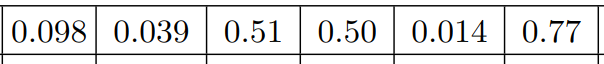

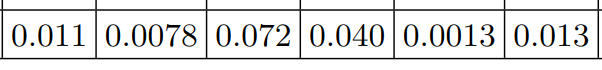

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0316, 0.0106, 0.0853, 0.0711, 0.0050])


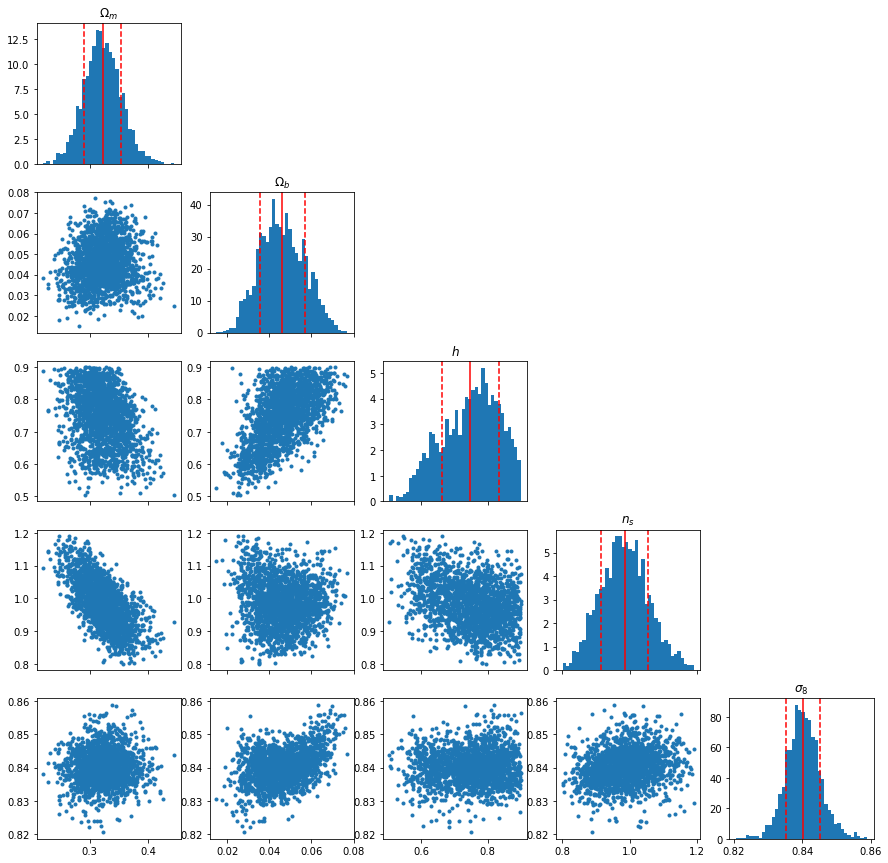

In [29]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_samples[:, i].mean(), color='r');
    axar[i, i].axvline(posterior_samples[:, i].mean()+posterior_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(posterior_samples[:, i].mean()-posterior_samples[:, i].std(), color='r', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')
    for j in range(0, i):
        axar[i, j].plot(posterior_samples[:, j], posterior_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])

print(posterior_samples.std(0))

In [30]:
ls /mnt/ceph/users/meickenberg/projects/quijote_harmonic_rings_128 -lisah

total 1.2G
1103419183177  512 drwxrwsr-x  2 meickenberg meickenberg 1.2G Feb 18 00:33 ./
1101283254954  512 drwxrwsr-x 21 meickenberg meickenberg 1.3T Feb 17 16:34 ../
1103419183199 119M -rw-rw-r--  1 meickenberg meickenberg 119M Feb 17 17:10 1c8d50b6be89447713c3d833ddee2847445bf398.npz
1103419183203 119M -rw-rw-r--  1 meickenberg meickenberg 119M Feb 17 17:52 7bc35d17fd3c3d4bc819af419fc89dfc6bb329f5.npz
1103419183204 119M -rw-rw-r--  1 meickenberg meickenberg 119M Feb 17 18:40 89f1b0a8c933d9037dbdf9fb1a44c8a8b70cf41f.npz
1103419183206 119M -rw-rw-r--  1 meickenberg meickenberg 119M Feb 17 20:36 e373bbe37b5b02765371f2b433bedba6badcb158.npz
1103419183207 591M -rw-rw-r--  1 meickenberg meickenberg 591M Feb 18 00:33 f27966395d56e877240abcf86d2f4a3bf7f5bce4.npz
1103419183205 119M -rw-rw-r--  1 meickenberg meickenberg 119M Feb 17 19:35 f289c06bca1027df021f1ea5b843936446d038d6.npz
1103419183178 7.0K -rw-rw-r--  1 meickenberg meickenberg 6.7K Feb 17 20:36 hash_table.dat


In [31]:
fname = "/mnt/ceph/users/meickenberg/projects/quijote_harmonic_rings_128/f27966395d56e877240abcf86d2f4a3bf7f5bce4.npz"

In [32]:
f = np.load(fname, allow_pickle=True)

In [33]:
w_lh = f['latin_hypercube']

In [34]:
w_lh.shape

(2000, 100, 91)

In [35]:
f['args'].item()['integral_powers'] # integral power 2 sits at index 8 (and also at 30)

'(0.125, 0.1767766952966369, 0.25, 0.3535533905932738, 0.5, 0.7071067811865476, 1.0, 1.4142135623730951, 2.0, 2.8284271247461903, 4.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000001, 1.5000000000000002, 1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5000000000000004, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1, 4.2, 4.3, 4.3999999999999995, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0)'

In [36]:
np.linalg.norm(w_lh[:, :, 8] - w_lh[:, :, 30])

0.0

In [37]:
w_l2 = w_lh[:, :, 8]

In [38]:
f['args'].item()['Ls']  # since for L2 aggregation, all harmonics lead to the same outcome, we pick L=0, ie the first fifth

'(0, 1, 2, 3, 4)'

In [39]:
w_l2 = w_l2[:, :w_lh.shape[1] // 5]

In [40]:
w_l2.shape  # It looks like we might be missing a possible smallest scale. Might need to recompute these

(2000, 20)

In [41]:
w_l2_train = w_l2[train]
w_l2_test = w_l2[test]

In [42]:

inference_l2 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_l2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l2_train.astype('float32')))

In [43]:
density_estimator_l2 = inference_l2.train(show_train_summary=True)


Neural network successfully converged after 163 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 163
        Best validation performance: 12.1525
        -------------------------
        


In [44]:
posterior_l2 = inference_l2.build_posterior(density_estimator_l2)

In [45]:
ii = 278

posterior_l2_samples = posterior_l2.sample((2000,), x=torch.from_numpy(w_l2_test[ii].astype('float32')))



Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0506, 0.0101, 0.0963, 0.1045, 0.0112])


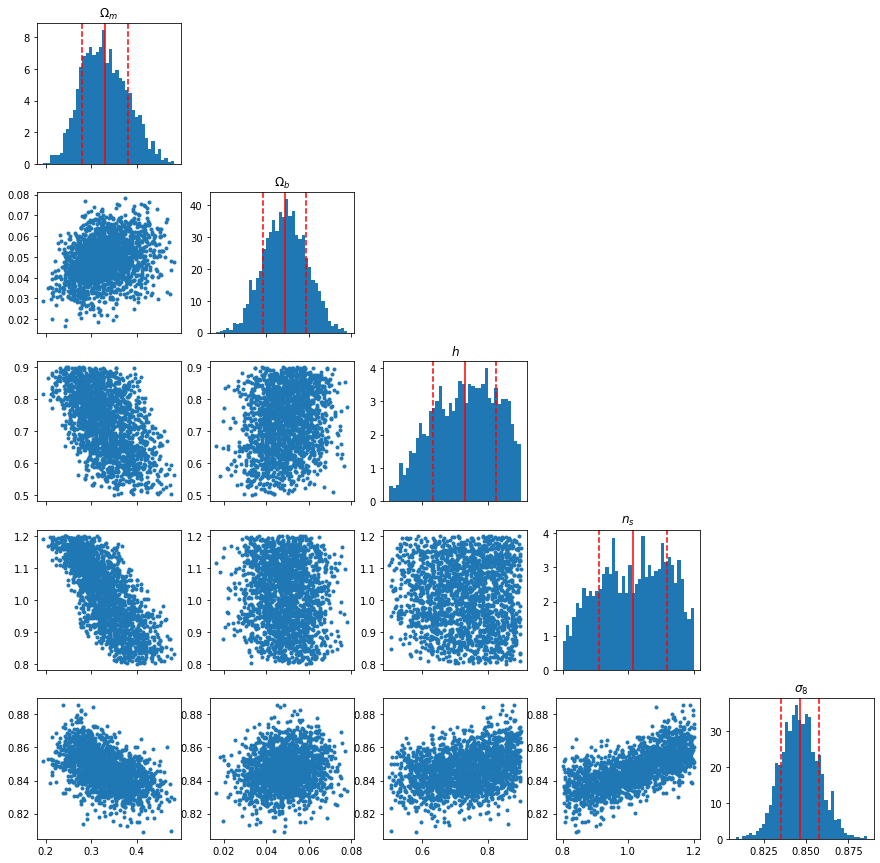

In [46]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l2_samples[:, i].mean(), color='r');
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()+posterior_l2_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()-posterior_l2_samples[:, i].std(), color='r', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')
    for j in range(0, i):
        axar[i, j].plot(posterior_l2_samples[:, j], posterior_l2_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])

print(posterior_l2_samples.std(0))

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0506, 0.0101, 0.0963, 0.1045, 0.0112])


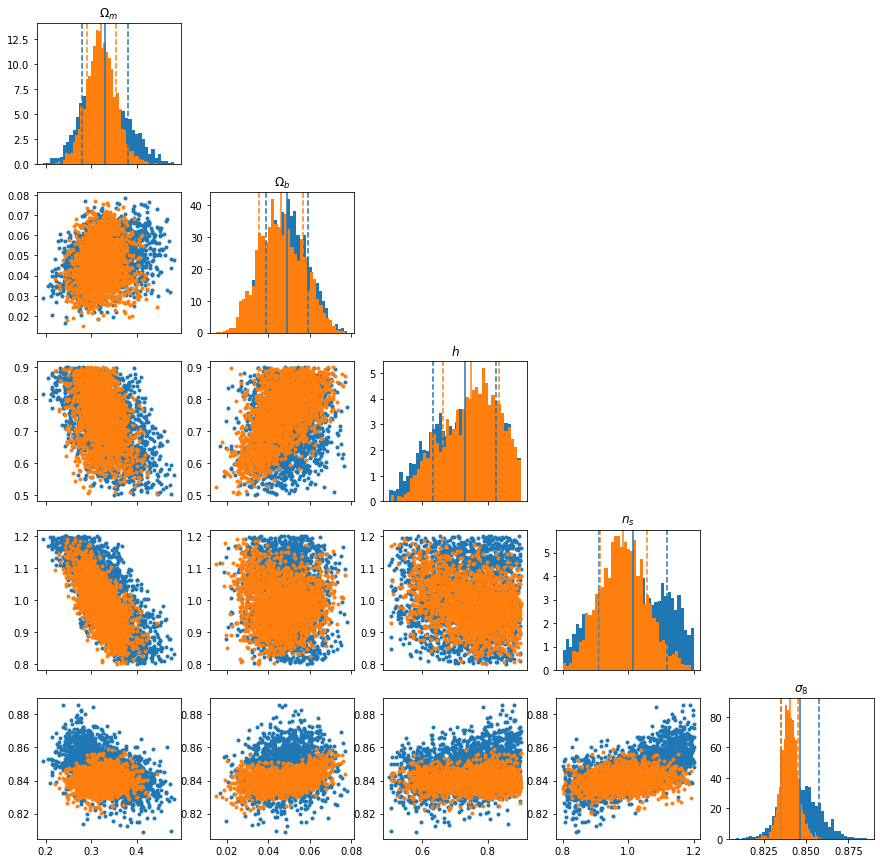

In [47]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l2_samples[:, i].mean(), color='tab:blue');
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()+posterior_l2_samples[:, i].std(), color='tab:blue', ls="--");
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()-posterior_l2_samples[:, i].std(), color='tab:blue', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')

    axar[i, i].hist(np.array(posterior_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_samples[:, i].mean(), color='tab:orange');
    axar[i, i].axvline(posterior_samples[:, i].mean()+posterior_samples[:, i].std(), color='tab:orange', ls="--");
    axar[i, i].axvline(posterior_samples[:, i].mean()-posterior_samples[:, i].std(), color='tab:orange', ls="--");

    
    for j in range(0, i):
        axar[i, j].plot(posterior_l2_samples[:, j], posterior_l2_samples[:, i], '.')
        axar[i, j].plot(posterior_samples[:, j], posterior_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])

print(posterior_l2_samples.std(0))

In [48]:
# ^ Pk constraints strictly better than wavelet l2 constraints. This is expected, because the l2 wavelets are functions of Pk and there are fewer of them


Now add l1 norm (large improvement expected)

In [49]:
w_l1l2 = w_lh[:, :, [6, 8]]

In [50]:
w_l1l2.shape

(2000, 100, 2)

First only keep isotropic wavelet

In [51]:
w_l1l2 = w_l1l2[:, :20]

In [52]:
w_l1l2.shape

(2000, 20, 2)

In [53]:
w_l1l2 = w_l1l2.reshape(w_l1l2.shape[0], -1)

In [61]:
w_l1l2.shape

(2000, 40)

In [54]:
w_l1l2_train = w_l1l2[train]
w_l1l2_test = w_l1l2[test]

In [55]:

inference_l1l2 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_l1l2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l1l2_train.astype('float32')))

In [56]:
density_estimator_l1l2 = inference_l1l2.train(show_train_summary=True)


Neural network successfully converged after 188 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 188
        Best validation performance: 12.7292
        -------------------------
        


In [57]:
posterior_l1l2 = inference_l1l2.build_posterior(density_estimator_l1l2)

In [58]:
ii = 278

posterior_l1l2_samples = posterior_l1l2.sample((2000,), x=torch.from_numpy(w_l1l2_test[ii].astype('float32')))



Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0527, 0.0103, 0.0981, 0.1050, 0.0102])


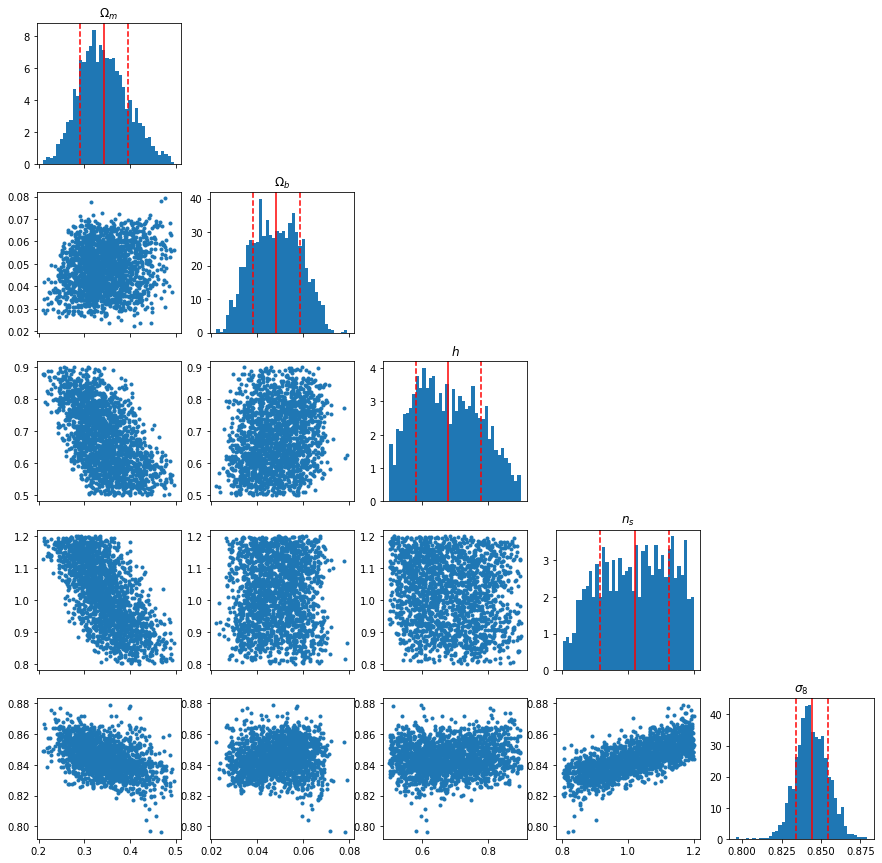

In [59]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_l1l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean(), color='r');
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean()+posterior_l1l2_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean()-posterior_l1l2_samples[:, i].std(), color='r', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')
    for j in range(0, i):
        axar[i, j].plot(posterior_l1l2_samples[:, j], posterior_l1l2_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])

print(posterior_l1l2_samples.std(0))

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0316, 0.0106, 0.0853, 0.0711, 0.0050])
tensor([0.0506, 0.0101, 0.0963, 0.1045, 0.0112])
tensor([0.0527, 0.0103, 0.0981, 0.1050, 0.0102])


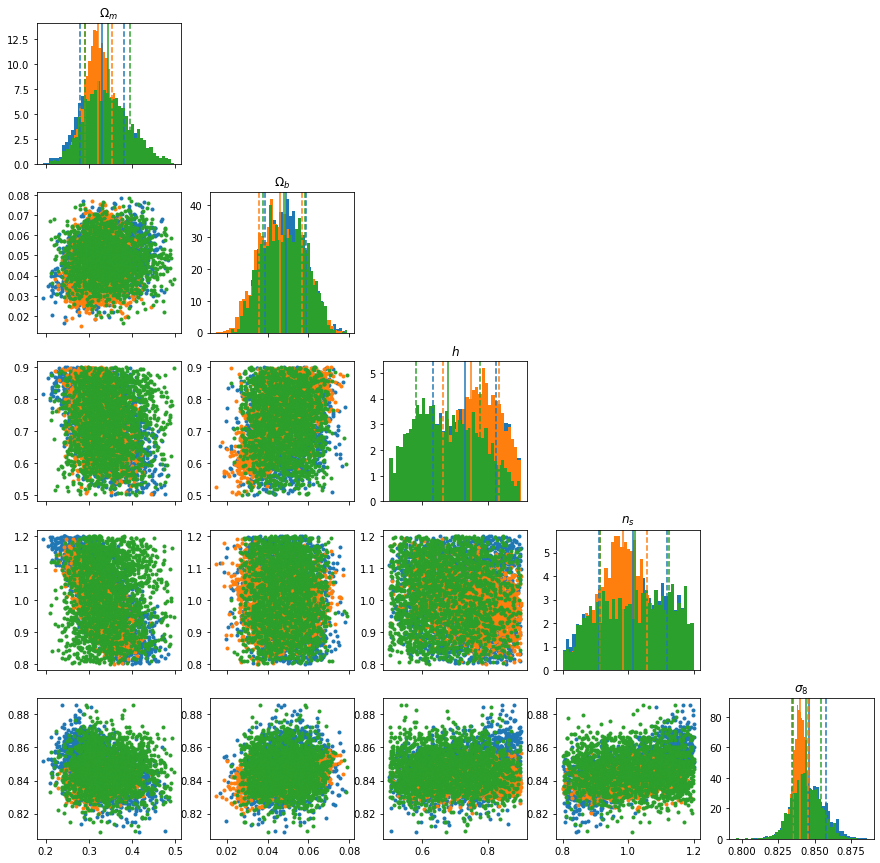

In [62]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l2_samples[:, i].mean(), color='tab:blue');
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()+posterior_l2_samples[:, i].std(), color='tab:blue', ls="--");
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()-posterior_l2_samples[:, i].std(), color='tab:blue', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')

    axar[i, i].hist(np.array(posterior_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_samples[:, i].mean(), color='tab:orange');
    axar[i, i].axvline(posterior_samples[:, i].mean()+posterior_samples[:, i].std(), color='tab:orange', ls="--");
    axar[i, i].axvline(posterior_samples[:, i].mean()-posterior_samples[:, i].std(), color='tab:orange', ls="--");

    axar[i, i].hist(np.array(posterior_l1l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean(), color='tab:green');
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean()+posterior_l1l2_samples[:, i].std(), color='tab:green', ls="--");
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean()-posterior_l1l2_samples[:, i].std(), color='tab:green', ls="--");
    
    for j in range(0, i):
        axar[i, j].plot(posterior_l2_samples[:, j], posterior_l2_samples[:, i], '.')
        axar[i, j].plot(posterior_samples[:, j], posterior_samples[:, i], '.')
        axar[i, j].plot(posterior_l1l2_samples[:, j], posterior_l2_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])


print(posterior_samples.std(0))
print(posterior_l2_samples.std(0))
print(posterior_l1l2_samples.std(0))

This doesn't seem to have helped as much as expected. Very possibly because of the missing small scales.

Next up: Add a higher harmonic order

In [63]:
w_l1l2h1 = w_lh[:, :, [6, 8]]

In [64]:
w_l1l2h1.shape

(2000, 100, 2)

keep isotropic wavelet and order 1 harmonic wavelet

In [65]:
w_l1l2h1 = w_l1l2h1[:, :40]

In [66]:
w_l1l2h1.shape

(2000, 40, 2)

In [67]:
w_l1l2h1 = w_l1l2h1.reshape(w_l1l2h1.shape[0], -1)

In [68]:
w_l1l2h1.shape

(2000, 80)

In [69]:
w_l1l2h1_train = w_l1l2h1[train]
w_l1l2h1_test = w_l1l2h1[test]

In [70]:

inference_l1l2h1 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_l1l2h1.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l1l2h1_train.astype('float32')))

In [71]:
density_estimator_l1l2h1 = inference_l1l2h1.train(show_train_summary=True)


Neural network successfully converged after 174 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 174
        Best validation performance: 12.6796
        -------------------------
        


In [72]:
posterior_l1l2h1 = inference_l1l2h1.build_posterior(density_estimator_l1l2h1)

In [73]:
ii = 278

posterior_l1l2h1_samples = posterior_l1l2h1.sample((2000,), x=torch.from_numpy(w_l1l2h1_test[ii].astype('float32')))



Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0470, 0.0106, 0.0964, 0.1010, 0.0091])


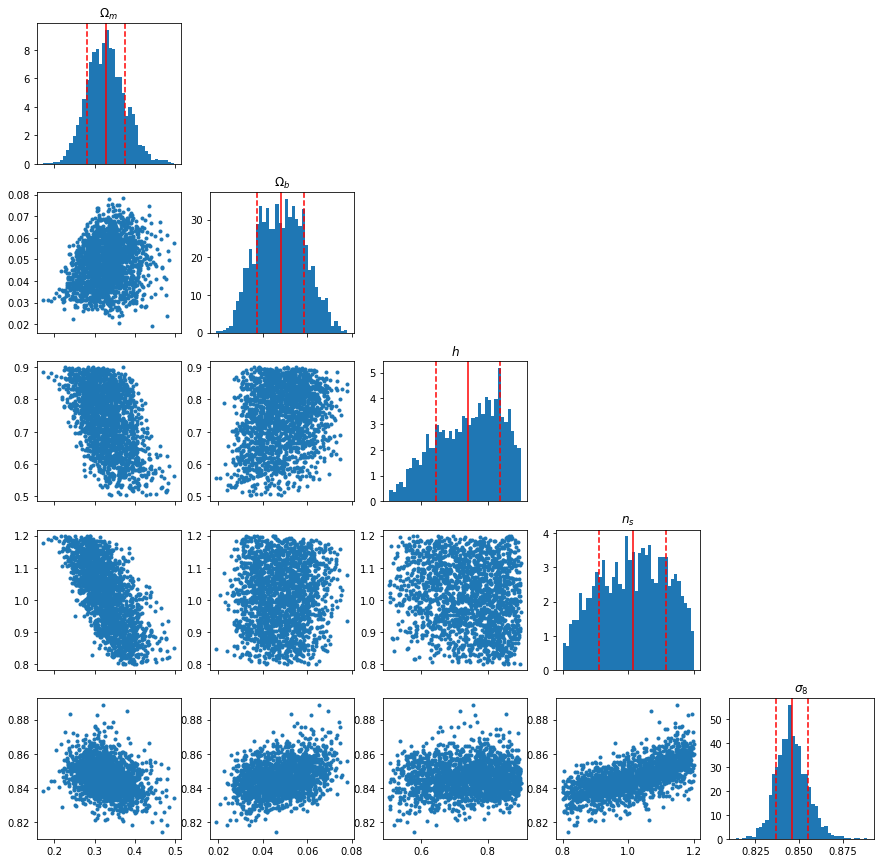

In [74]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_l1l2h1_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l1l2h1_samples[:, i].mean(), color='r');
    axar[i, i].axvline(posterior_l1l2h1_samples[:, i].mean()+posterior_l1l2h1_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(posterior_l1l2h1_samples[:, i].mean()-posterior_l1l2h1_samples[:, i].std(), color='r', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')
    for j in range(0, i):
        axar[i, j].plot(posterior_l1l2h1_samples[:, j], posterior_l1l2h1_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])

print(posterior_l1l2h1_samples.std(0))

[0.3313  0.03521 0.6567  0.9885  0.8377 ]
0
1
2
3
4
tensor([0.0316, 0.0106, 0.0853, 0.0711, 0.0050])
tensor([0.0506, 0.0101, 0.0963, 0.1045, 0.0112])
tensor([0.0527, 0.0103, 0.0981, 0.1050, 0.0102])


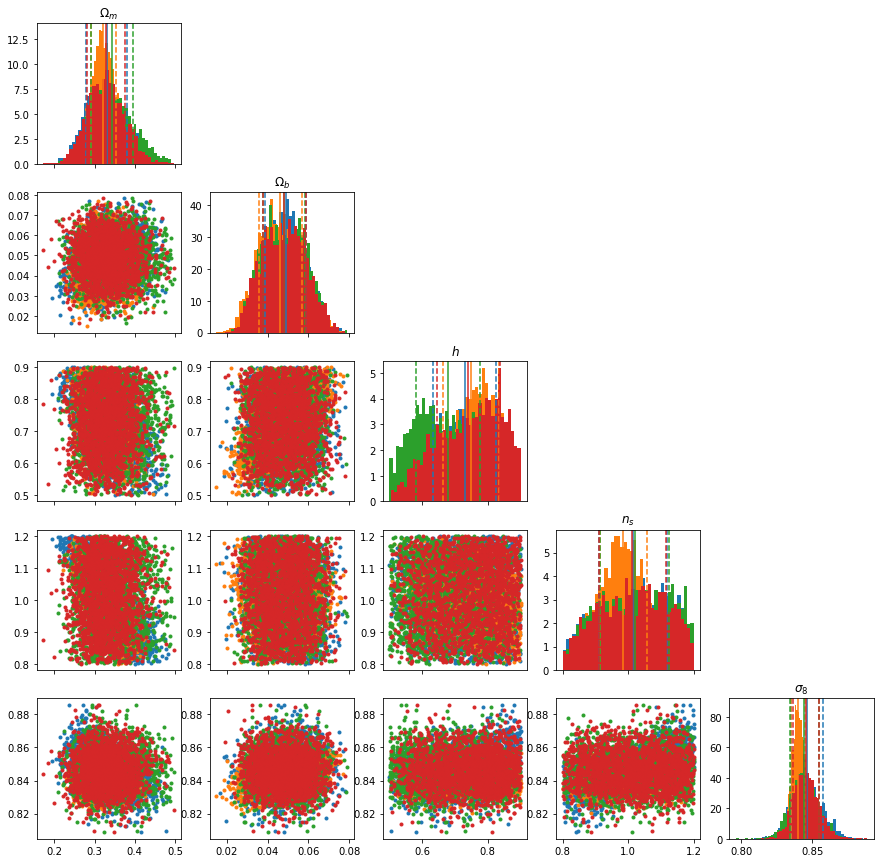

In [75]:
ndim = 5

print(params_test[ii])

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l2_samples[:, i].mean(), color='tab:blue');
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()+posterior_l2_samples[:, i].std(), color='tab:blue', ls="--");
    axar[i, i].axvline(posterior_l2_samples[:, i].mean()-posterior_l2_samples[:, i].std(), color='tab:blue', ls="--");
    #axar[i, i].axvline(cosmo_test[ii][i], color='k')

    axar[i, i].hist(np.array(posterior_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_samples[:, i].mean(), color='tab:orange');
    axar[i, i].axvline(posterior_samples[:, i].mean()+posterior_samples[:, i].std(), color='tab:orange', ls="--");
    axar[i, i].axvline(posterior_samples[:, i].mean()-posterior_samples[:, i].std(), color='tab:orange', ls="--");

    axar[i, i].hist(np.array(posterior_l1l2_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean(), color='tab:green');
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean()+posterior_l1l2_samples[:, i].std(), color='tab:green', ls="--");
    axar[i, i].axvline(posterior_l1l2_samples[:, i].mean()-posterior_l1l2_samples[:, i].std(), color='tab:green', ls="--");
    
    axar[i, i].hist(np.array(posterior_l1l2h1_samples[:, i]), density=True, bins=40);
    axar[i, i].axvline(posterior_l1l2h1_samples[:, i].mean(), color='tab:red');
    axar[i, i].axvline(posterior_l1l2h1_samples[:, i].mean()+posterior_l1l2h1_samples[:, i].std(), color='tab:red', ls="--");
    axar[i, i].axvline(posterior_l1l2h1_samples[:, i].mean()-posterior_l1l2h1_samples[:, i].std(), color='tab:red', ls="--");
    
    for j in range(0, i):
        axar[i, j].plot(posterior_l2_samples[:, j], posterior_l2_samples[:, i], '.')
        axar[i, j].plot(posterior_samples[:, j], posterior_samples[:, i], '.')
        axar[i, j].plot(posterior_l1l2_samples[:, j], posterior_l2_samples[:, i], '.')
        axar[i, j].plot(posterior_l1l2h1_samples[:, j], posterior_l2_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])


print(posterior_samples.std(0))
print(posterior_l2_samples.std(0))
print(posterior_l1l2_samples.std(0))

Same mess. OK need to recompute coefs